In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# iris

In [5]:
# ファイル読み込み
in_file = '../data/iris.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep=',')
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


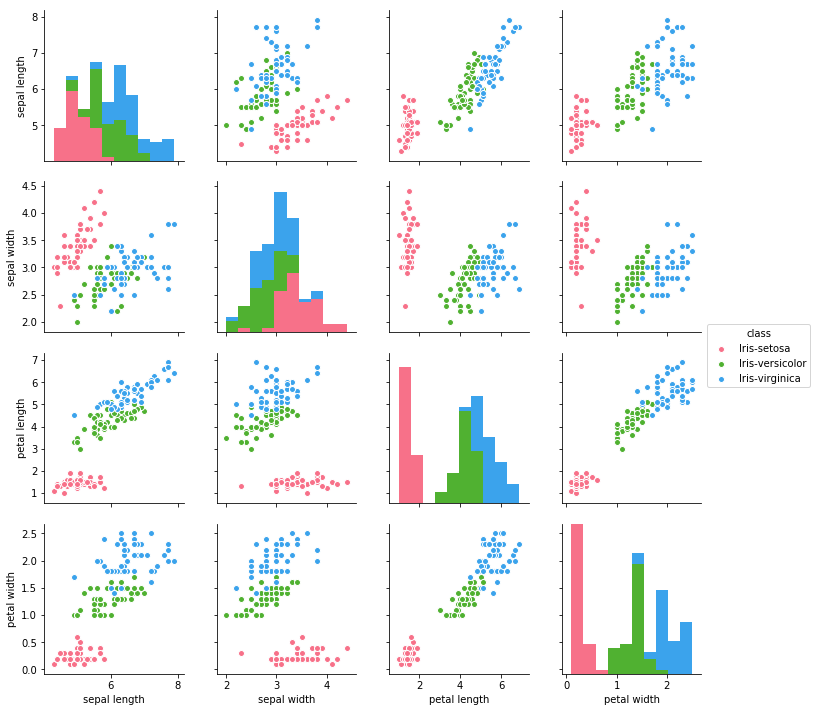

In [8]:
# 各特徴量で散布図作成
sns.pairplot(df, hue='class', palette='husl');
plt.show()

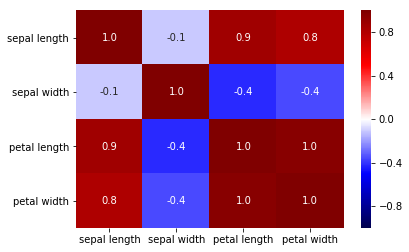

In [9]:
# 相関の確認
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat,
            cmap='seismic',
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

In [21]:
anomaly_label = df['class']=='Iris-versicolor'
anomaly_label = np.where(anomaly_label, 1, 0)
print('異常ラベルの数', np.sum(anomaly_label==0))
print('正常ラベルの数', np.sum(anomaly_label!=0))

異常ラベルの数 100
正常ラベルの数 50


In [39]:
# バージカラーとそうでない品種を分離
df_nonversi = df[df['class']!='Iris-versicolor']
df_versi = df[df['class']=='Iris-versicolor']

In [50]:
X_train = df_nonversi.drop('class', axis=1)
y_train = np.where(df_nonversi['class']!='Iris-versicolor', 0, 1)
X_test = df_versi
y_test = 

SyntaxError: invalid syntax (<ipython-input-50-62676f2a4ae1>, line 4)

In [47]:
def MT(X_train, X_test, y_test):
    # 標準化
    sc = StandardScaler()
    X_std = sc.fit_transform(X_train)
    
    # 標準化したXの相関係数行列
    X_std_corr = np.corrcoef(X_std, rowvar=False)
    
    # 逆行列の計算
    X_std_corr_inv = np.linalg.inv(X_std_corr) 
    
    # テスト
    X_test_std = sc.transform(X_test)
    X_test_dist = np.array([np.dot(x, np.dot(X_std_corr_inv, x)) for x in X_test_std])/X_test.shape[1]
    
    # 描画
    plt.plot(np.where(y_test==0)[0], X_test_dist[np.where(y_test==0)[0]], 'o', alpha=.3)
    plt.plot(np.where(y_test!=0)[0], X_test_dist[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.7)
    plt.show()

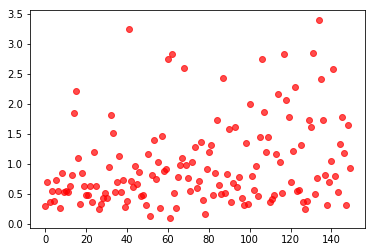

In [48]:
MT(X_train, X_test, y_test)

In [49]:
y_test

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
5         Iris-setosa
6         Iris-setosa
7         Iris-setosa
8         Iris-setosa
9         Iris-setosa
10        Iris-setosa
11        Iris-setosa
12        Iris-setosa
13        Iris-setosa
14        Iris-setosa
15        Iris-setosa
16        Iris-setosa
17        Iris-setosa
18        Iris-setosa
19        Iris-setosa
20        Iris-setosa
21        Iris-setosa
22        Iris-setosa
23        Iris-setosa
24        Iris-setosa
25        Iris-setosa
26        Iris-setosa
27        Iris-setosa
28        Iris-setosa
29        Iris-setosa
            ...      
120    Iris-virginica
121    Iris-virginica
122    Iris-virginica
123    Iris-virginica
124    Iris-virginica
125    Iris-virginica
126    Iris-virginica
127    Iris-virginica
128    Iris-virginica
129    Iris-virginica
130    Iris-virginica
131    Iris-virginica
132    Iris-virginica
133    Iris-virginica
134    Iri